In [1]:
# Importing all the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Data preparation for Boston dataset

# Loading the Boston Housing dataset --- I got an import error that showed me that the original dataset was removed from the scikit
# learn due to some ethical issues and asked me to import the dataset from original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

# Shuffle the dataset
shuffle_index = np.random.permutation(len(X))
X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]

# Split the shuffled dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [3]:
# Model training and hyperparameter tuning

# Parameters for hyperparameter tuning
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 5, 10, 15]
max_features_value = int(np.log2(X_train.shape[1]))

# Random Forest Regressor
rf_regressor = RandomForestRegressor(criterion='squared_error', random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_regressor,
                           param_grid={'n_estimators': n_estimators_values,
                                       'max_depth': max_depth_values,
                                       'max_features': [max_features_value]},
                           scoring='neg_mean_squared_error', cv=5)

# though i have an explicitly defined validation dataset, still i am using cv part for intenal validation under the gridsearch to enhance consistency and
# It allows GridSearchCV to perform cross-validation during the grid search process. While I have a validation set, cross-validation
# can still offer valuable information about the model's performance on different subsets of taining data.

grid_search.fit(X_train, y_train)

# Printing Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Model with the best hyperparameters
best_rf_model = RandomForestRegressor(criterion='squared_error', random_state=42, **best_params)
best_rf_model.fit(X_train, y_train)

Best Hyperparameters: {'max_depth': 10, 'max_features': 3, 'n_estimators': 100}


RandomForestRegressor(max_depth=10, max_features=3, random_state=42)

'External Validation Set' Mean Squared Error: 11.893096132989067
'Test' Mean Squared Error: 11.647533249222937


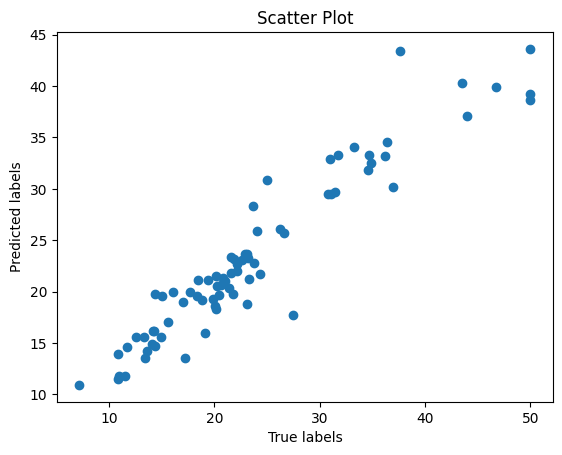

In [4]:
# Evaluation with trained model corresponding to best hyperparameters

# Evaluation of the trained model on valdiation set
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print("'External Validation Set' Mean Squared Error:", val_mse)

# Evaluation of the trained model on testing set
test_predictions = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print("'Test' Mean Squared Error:", test_mse)

# Scatter plot for predicted target values vs true target values
plt.scatter(y_test, test_predictions)

# Add labels and title
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [5]:
# Data preparation for cancer dataset

# Loading the dataset
breast_cancer = load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target

# Shuffling the dataset
shuffle_index = np.random.permutation(len(X))
X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]

# Split the shuffled dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (398, 30)
Validation set shape: (85, 30)
Testing set shape: (86, 30)


In [6]:
# Custom implementation of Adaboost Classifier

class Ada_Boost_Classifier():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []

    def fit(self, X, y):
        # Initializing with equal weights to all
        weights = np.ones(X.shape[0]) / X.shape[0]

        for _ in range(self.n_estimators):
            # Weak learner will be a Stump (Tree with depth equals 1)
            estimator = DecisionTreeClassifier(max_depth=1)
            estimator.fit(X, y, sample_weight=weights)
            y_pred = estimator.predict(X)
            errors = weights * (y_pred != y)

            # Computing the error rate and each estimator's 'say'
            error_rate = np.sum(errors) / np.sum(weights)
            estimator_say = np.log((1 - error_rate) / error_rate) / 2

            # Updating sample weights
            weights *= np.exp(np.where(y_pred == y, -estimator_say, estimator_say))

            # Normalization
            weights /= np.sum(weights)

            # Store the weak learner and its say
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_say)

    def predict(self, X):
        # Initialize array to store final predictions
        final_predictions = []

        # Iterate over each sample in the input data X
        for x in X:
            # Initialize sums for class 0 and class 1 for the current sample
            sum_class_0 = 0
            sum_class_1 = 0

            # Iterate over each weak learner's prediction and its corresponding weight
            for estimator, weight in zip(self.estimators, self.estimator_weights):
                # Make prediction for the current sample using the weak learner
                prediction = estimator.predict([x])[0]  # predict method expects a 2D array, so we pass [x] and take the first element of the result
                # Update sums based on predictions and weights
                if prediction == 0:
                    sum_class_0 += weight
                elif prediction == 1:
                    sum_class_1 += weight

            # Choose the final class based on which sum is larger for the current sample
            if sum_class_0 > sum_class_1:
                final_predictions.append(0)
            else:
                final_predictions.append(1)

        return np.array(final_predictions)


In [7]:
# Model training and hyperparameter tuning on custom implementation

n_estimators_values = [50, 100, 150]

# Performing hyperparameter tuning with self implemented Adaboost
# I am using validation set to get the best model

best_accuracy = 0
best_n_estimators = None

for n_estimators in n_estimators_values:
    adaboost = Ada_Boost_Classifier(n_estimators= n_estimators)
    adaboost.fit(X_train, y_train)
    y_pred = adaboost.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_estimators = n_estimators

print("Best number of weak learners: ", best_n_estimators)
print("Accuracy for best number of weak learners: ", best_accuracy)

Best number of weak learners:  100
Accuracy for best number of weak learners:  0.9882352941176471


In [8]:
# Evaluation with trained model corresponding to best hyperparameters

adaboost = Ada_Boost_Classifier(n_estimators= best_n_estimators)
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Generating Classification report and confusioon matrix
from sklearn.metrics import classification_report
report_custom = classification_report(y_test, y_pred)
confusion_mat_custom = confusion_matrix(y_test, y_pred)

SKLearn AdaBoost Classifier:
Best Number of Weak Learners (n_estimators): 150
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.94      0.98      0.96        51

    accuracy                           0.95        86
   macro avg       0.96      0.95      0.95        86
weighted avg       0.95      0.95      0.95        86



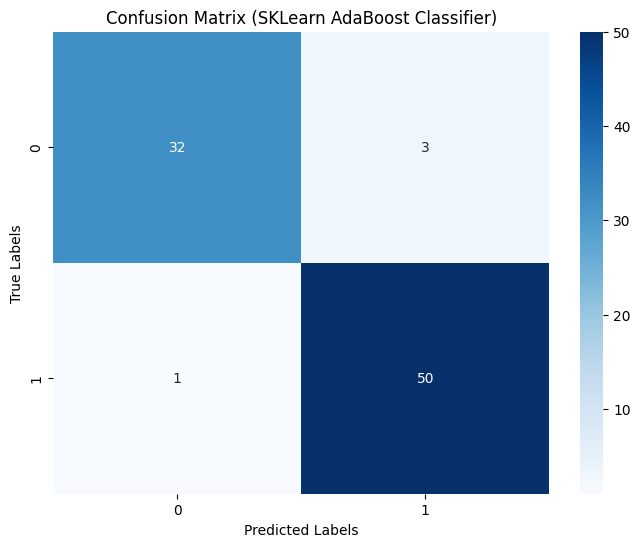


Custom Implementation:
Best Number of Weak Learners (n_estimators): 100
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.96      0.98      0.97        51

    accuracy                           0.97        86
   macro avg       0.97      0.96      0.96        86
weighted avg       0.97      0.97      0.97        86



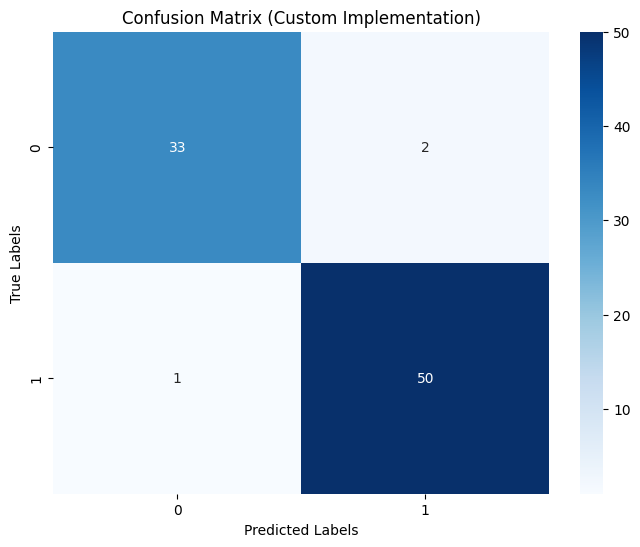

In [9]:
# Implementation of Scikit-learn's AdaBoost Classifier

param_grid = {'n_estimators': [50, 100, 150]}
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_n_estimators_sk = grid_search.best_params_['n_estimators']
ada_boost = AdaBoostClassifier(n_estimators=best_n_estimators_sk)
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)

# Generating Classification Report and Confusion Matrix
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Printing and comparing results
print("SKLearn AdaBoost Classifier:")
print("Best Number of Weak Learners (n_estimators):", best_n_estimators_sk)
print("Classification Report:")
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (SKLearn AdaBoost Classifier)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nCustom Implementation:")
print("Best Number of Weak Learners (n_estimators):", best_n_estimators)
print("Classification Report:")
print(report_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_custom, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Custom Implementation)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()